DiffEdit's Three step pipeline
1. Step A:
- Using Query Text: Text to represent the new object which will replace the old object
- Using Reference Text: Text to represent the input image
    - Query and Reference Text are used to produce the noise estimation area for the input image. The difference in the noise is used to as a mask which would be used to specify the region of revererse diffusion.
2. Step B: Forward Diffusion process of the input image using Auto Encoders and UNeT to get the latent space of the image
3. Step C: The latent are decoded with VAE of the diffusion Model conditioned on the text query, using the mask as a guidance such that pixels inside the mask are replaced with new generated pixels during reverse diffusion.

In [ ]:
!pip install diffusers transformers accelerate scipy safetensors

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 10.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 314.1/314.1 kB 17.1 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylin

In [ ]:
import torch
from diffusers import DDIMScheduler, DDIMInverseScheduler, StableDiffusionDiffEditPipeline
from diffusers.utils import load_image, make_image_grid
from transformers import AutoTokenizer, T5ForConditionalGeneration

In [ ]:
pipeline = StableDiffusionDiffEditPipeline.from_pretrained(
    'stabilityai/stable-diffusion-2-1',
    torch_dtype=torch.float16,
    safety_checker=None,
    use_safetensors=True,
)

pipeline.scheduler = DDIMScheduler.from_config(pipeline.scheduler.config)
pipeline.inverse_scheduler = DDIMInverseScheduler.from_config(pipeline.scheduler.config)
pipeline.enable_model_cpu_offload()
pipeline.enable_vae_slicing()

model_index.json:   0%|          | 0.00/537 [00:00<?, ?B/s]

Fetching 13 files:   0%|          | 0/13 [00:00<?, ?it/s]

scheduler/scheduler_config.json:   0%|          | 0.00/345 [00:00<?, ?B/s]

(…)ature_extractor/preprocessor_config.json:   0%|          | 0.00/342 [00:00<?, ?B/s]

text_encoder/config.json:   0%|          | 0.00/633 [00:00<?, ?B/s]

tokenizer/merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

tokenizer/special_tokens_map.json:   0%|          | 0.00/460 [00:00<?, ?B/s]

tokenizer/vocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

tokenizer/tokenizer_config.json:   0%|          | 0.00/824 [00:00<?, ?B/s]

unet/config.json:   0%|          | 0.00/939 [00:00<?, ?B/s]

vae/config.json:   0%|          | 0.00/611 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.36G [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/3.46G [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/335M [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

The config attributes {'skip_prk_steps': True} were passed to DDIMInverseScheduler, but are not expected and will be ignored. Please verify your scheduler_config.json configuration file.


In [ ]:
# Loading image for editing
img_url = "https://images.unsplash.com/photo-1515859005217-8a1f08870f59?q=80&w=2010&auto=format&fit=crop&ixlib=rb-4.0.3&ixid=M3wxMjA3fDB8MHxwaG90by1wYWdlfHx8fGVufDB8fHx8fA%3D%3D"
raw_image = load_image(img_url).resize((768,768))

In [ ]:
# Generating mask
from PIL import Image

source_prompt = 'a white scooter'
target_prompt = 'a small flower port containing tulips'
mask_image = pipeline.generate_mask(
    image=raw_image,
    source_prompt=source_prompt,
    target_prompt=target_prompt,
)
mask_image

array([[[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 1],
        [0, 0, 0, ..., 0, 1, 0],
        [0, 0, 0, ..., 1, 1, 0]]])

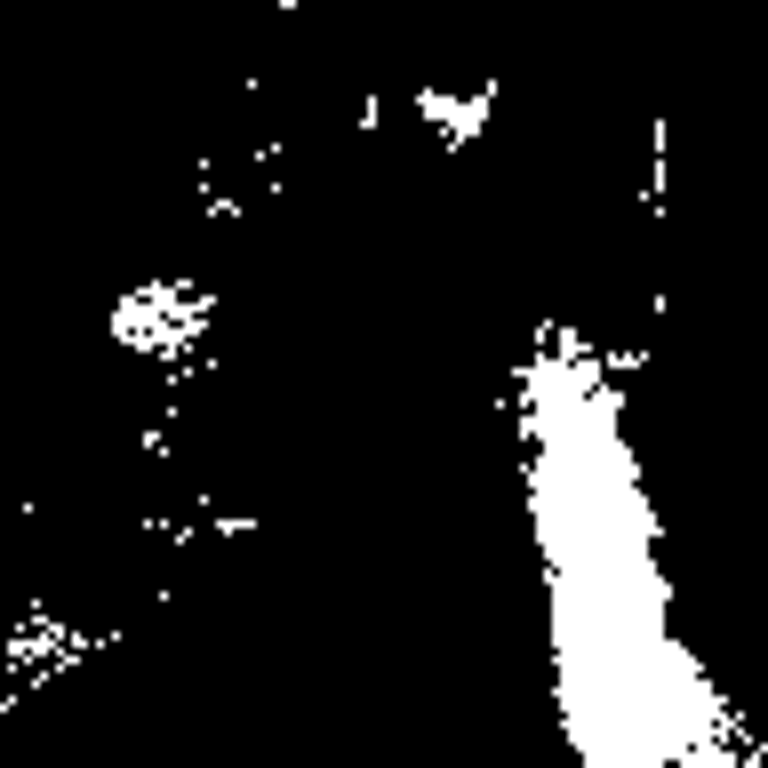

In [ ]:
Image.fromarray((mask_image.squeeze()*255).astype('uint8'), 'L').resize((768,768))

  0%|          | 0/40 [00:00<?, ?it/s]

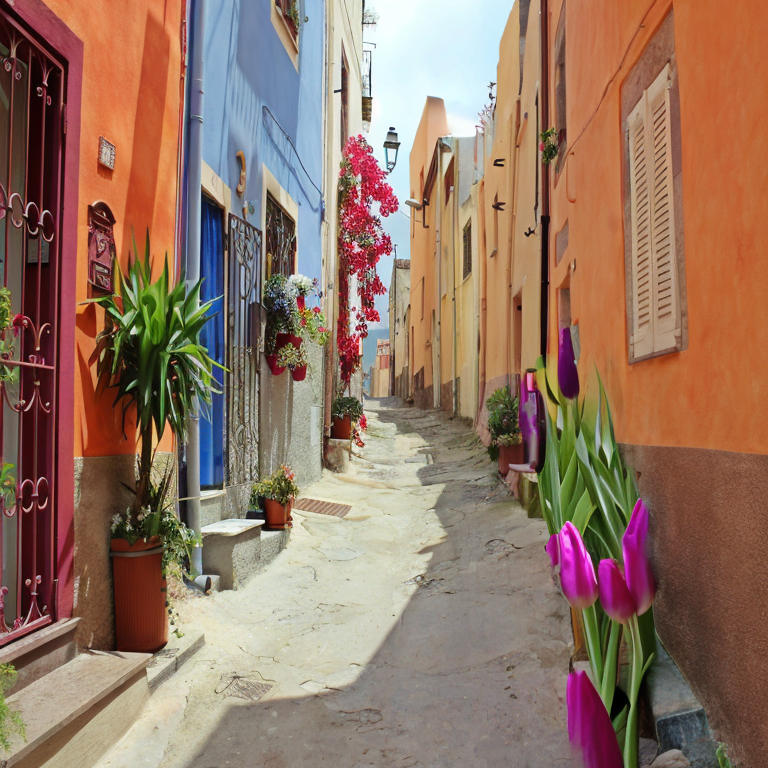

In [ ]:
output_image = pipeline(
    prompt=target_prompt,
    mask_image=mask_image,
    image_latents=inverted,
    negative_prompt=source_prompt,
).images[0]
output_image

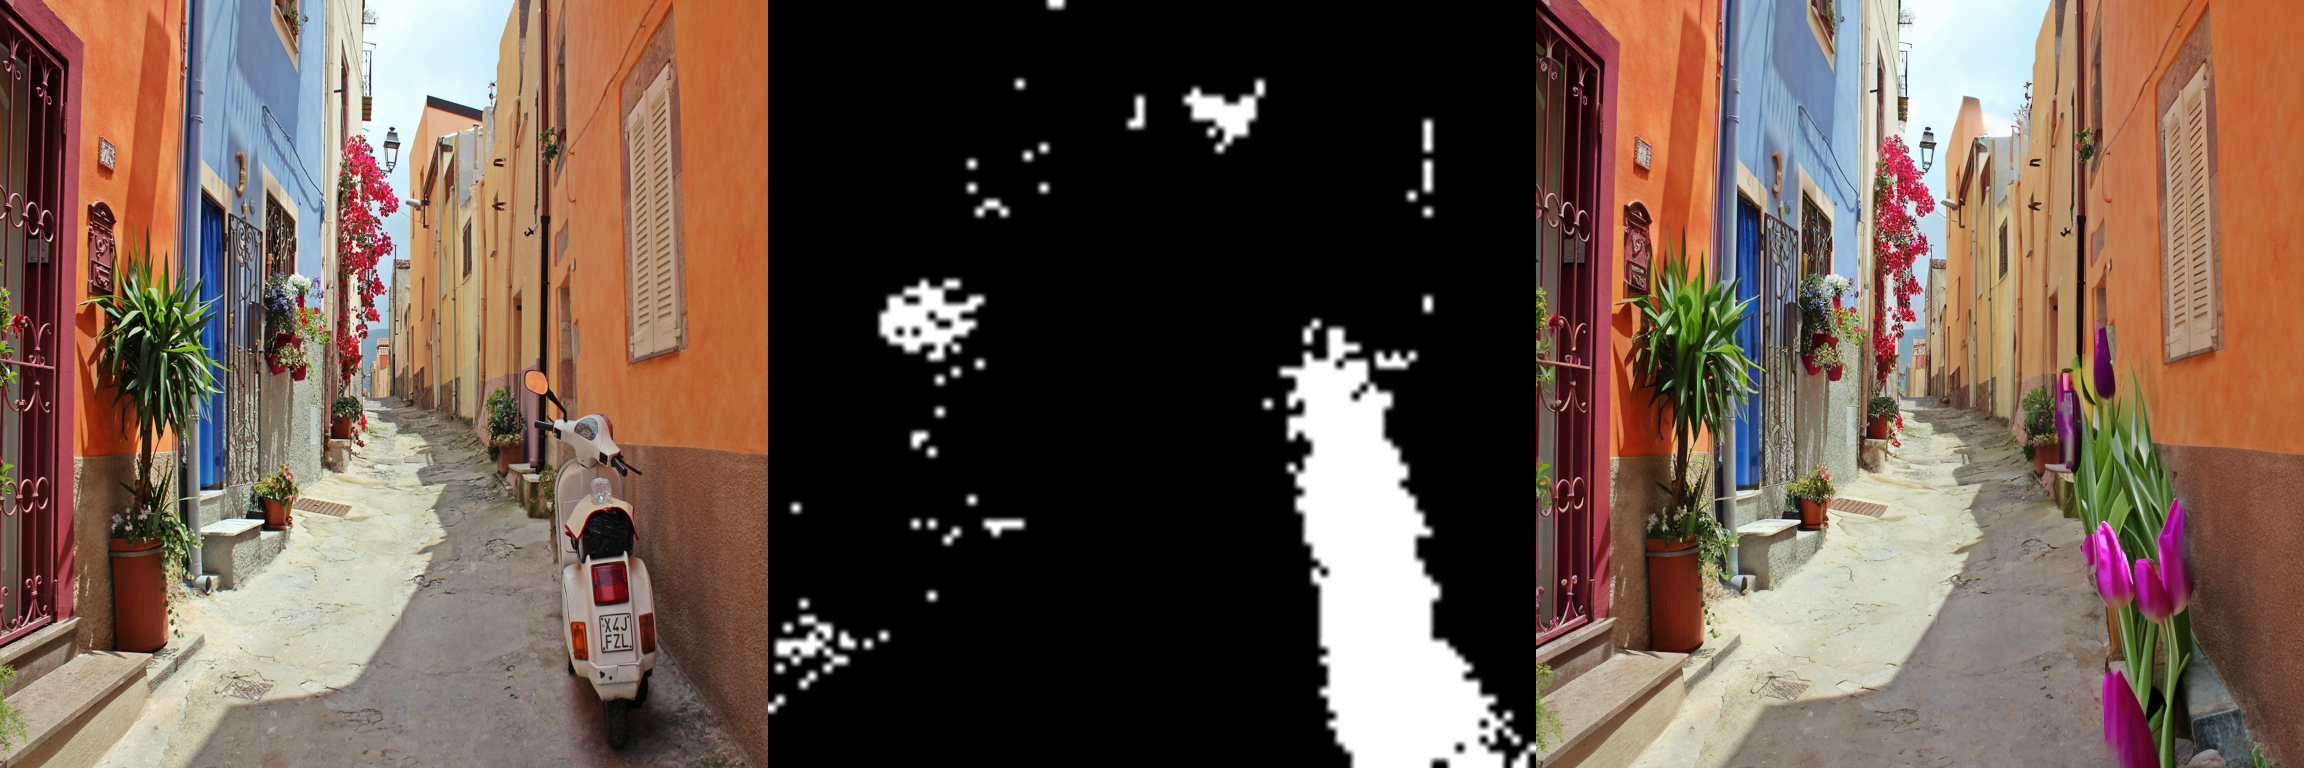

In [ ]:
mask_image = Image.fromarray((mask_image.squeeze()*255).astype("uint8"), "L").resize((768, 768))
make_image_grid([raw_image, mask_image, output_image], rows=1, cols=3)

Source and target embedding can be automatically created instead of creating them manually

In [ ]:
tokenizer = AutoTokenizer.from_pretrained("google/flan-t5-large")
model = T5ForConditionalGeneration.from_pretrained("google/flan-t5-large",
                                                   device_map='auto',
                                                   torch_dtype=torch.float16)